# Quick Start Tutorial: Feature Engineering

## Learning Objectives

In this tutorial you will learn:
1. How to create and use views
2. How features, entities, and observation sets are used together
3. How to create a lookup feature
4. How to create an aggregate feature
5. How to save features
6. How to reuse features
7. How to create a feature list
8. How to materialize feature values

## Set up the prerequisites

Learning Objectives

In this section you will:
* start your local featurebyte server
* import libraries
* learn about catalogs
* activate a pre-built catalog

### Load the featurebyte library and connect to the local instance of featurebyte

In [1]:
# library imports
import pandas as pd
import numpy as np

# load the featurebyte SDK
import featurebyte as fb

print("FeatureByte version " + fb.version)

# start the local server, then wait for it to be healthy before proceeding
fb.playground()

2023-03-27 19:05:13.261 | INFO     | featurebyte.docker.manager:start_playground:305 | Starting featurebyte service | {}


FeatureByte version 0.1.4


2023-03-27 19:05:21.233 | INFO     | featurebyte.docker.manager:start_playground:307 | Starting local spark service | {}
2023-03-27 19:05:28.080 | INFO     | featurebyte.docker.manager:start_playground:310 | Starting documentation service | {}
2023-03-27 19:05:34.971 | INFO     | featurebyte.docker.manager:start_playground:314 | Creating local spark feature store | {}
2023-03-27 19:05:35.493 | INFO     | featurebyte.docker.manager:start_playground:336 | Dataset grocery already exists, skipping import | {}
2023-03-27 19:05:35.494 | INFO     | featurebyte.docker.manager:start_playground:336 | Dataset healthcare already exists, skipping import | {}
2023-03-27 19:05:35.494 | INFO     | featurebyte.docker.manager:start_playground:336 | Dataset creditcard already exists, skipping import | {}


### Concept: Catalog

A FeatureByte Catalog serves as a centralized repository for storing metadata about FeatureByte objects such as tables, entities, features, and feature lists associated with a specific domain. It functions as an effective tool for facilitating collaboration among team members working on similar use cases or utilizing the same data source within a data warehouse.

### Create a pre-built catalog for this tutorial, with the data, metadata, and features already set up

Note that creating a pre-built catalog is not a step you will do in real-life. This is a function specific to this quick-start tutorial to quickly skip over many of the preparatory steps and get you to a point where you can materialize features.

In a real-life project you would do data modeling, declaring the tables, entities, and the associated metadata. This would not be a frequent task, but forms the basis for best-practice feature engineering.

In [2]:
# get the functions to create a pre-built catalog
from prebuilt_catalogs import *

# create a new catalog for this tutorial
catalog_name = create_tutorial_catalog(PrebuiltCatalog.QuickStartFeatureEngineeering)

Cleaning up any existing tutorial catalogs
Building a quick start catalog for feature engineering named [quick start feature engineering 20230327:1905]
Creating new catalog
Catalog created
Registering the source tables
Registering the entities
Tagging the entities to columns in the data tables
Populating the feature store with example features
Catalog created and pre-populated with data and features


### Example: Activate an existing catalog

In [3]:
# you can activate an existing catalog
catalog = fb.Catalog.activate(catalog_name)

## Create Views of Tables within the Catalog

Learning Objectives

In this section you will learn:
* about tables and table types
* about the dataset used in this tutorial
* how to load tables
* about views
* how to create views

### Concept: Catalog table

A Catalog Table serves as a logical representation of a source table within the Catalog. The Catalog Table does not store data itself, but instead provides a way to access the source table and centralize essential metadata for feature engineering.

### Concept: Standard table types

Featurebyte is designed to use data warehouses as the primary data source.

Featurebyte supports four of the most common types of data table.

1. an <b>event</b> table is a type of Catalog Table that contains rows for specific business event that was measured at a particular moment in time. Event tables can take various forms, such as an Order table in E-commerce, Credit Card Transactions in Banking, Doctor Visits in Healthcare, and Clickstream on the Internet.  
2. An <b>item</b> is a type of Catalog Table that represents a table in the data warehouse containing in-depth details about a business event. For instance, an Item table can contain information about Product Items purchased in Customer Orders or Drug Prescriptions issued during Doctor Visits by Patients.
3. A <b>dimension</b> table is a Catalog Table that represents a table in the data warehouse that stores static descriptive information such as a birth date or product category. Using a Dimension table requires special attention. If the data in the table changes slowly, it is not advisable to use it because these changes can cause significant data leaks during model training and adversely affect the inference performance. In such cases, it is recommended to use a Slowly Changing Dimension table of Type 2 that maintains a history of changes. For example, dimension data could contain the product group of each grocery product.
4. A <b>slowly changing dimension</b> (SCD) table is a type of Catalog Table that represents a table in a data warehouse that contains data that changes slowly and unpredictably over time. There are two main types of SCDs: Type 1, which overwrites old data with new data, and Type 2, which maintains a history of changes by creating a new record for each change. FeatureByte only supports the use of Type 2 SCDs since SCDs of Type 1 may cause data leaks during model training and poor performance during inference. An SCD Table of Type 2 utilizes a natural key to distinguish each active row and facilitate tracking of changes over time. The SCD table employs effective and expiration date columns to determine the active status of a row. In certain instances, an active flag column may replace the expiration date column to indicate if a row is currently active. For example, slowly changing dimension data could contain customer data, which has attributes that need versioning, such as when a customer changes address.

### Introduction to the French grocery dataset

This tutorial uses the French grocery dataset that has been pre-installed in quick-start feature engineering catalog. It consists of 4 data tables recording grocery purchasing activity for each customer.<br>

1. <b>GroceryCustomer</b> is a slowly changing dimension table containing customer attributes.
2. <b>GroceryInvoice</b> is an event table containing grocery purchase transactions.
3. <b>InvoiceItems</b> is an event items table containing details of the basket of grocery items purchased in each transaction.
4. <b>GroceryProduct</b> is a dimension table containing the product attributes for each grocery item being sold.

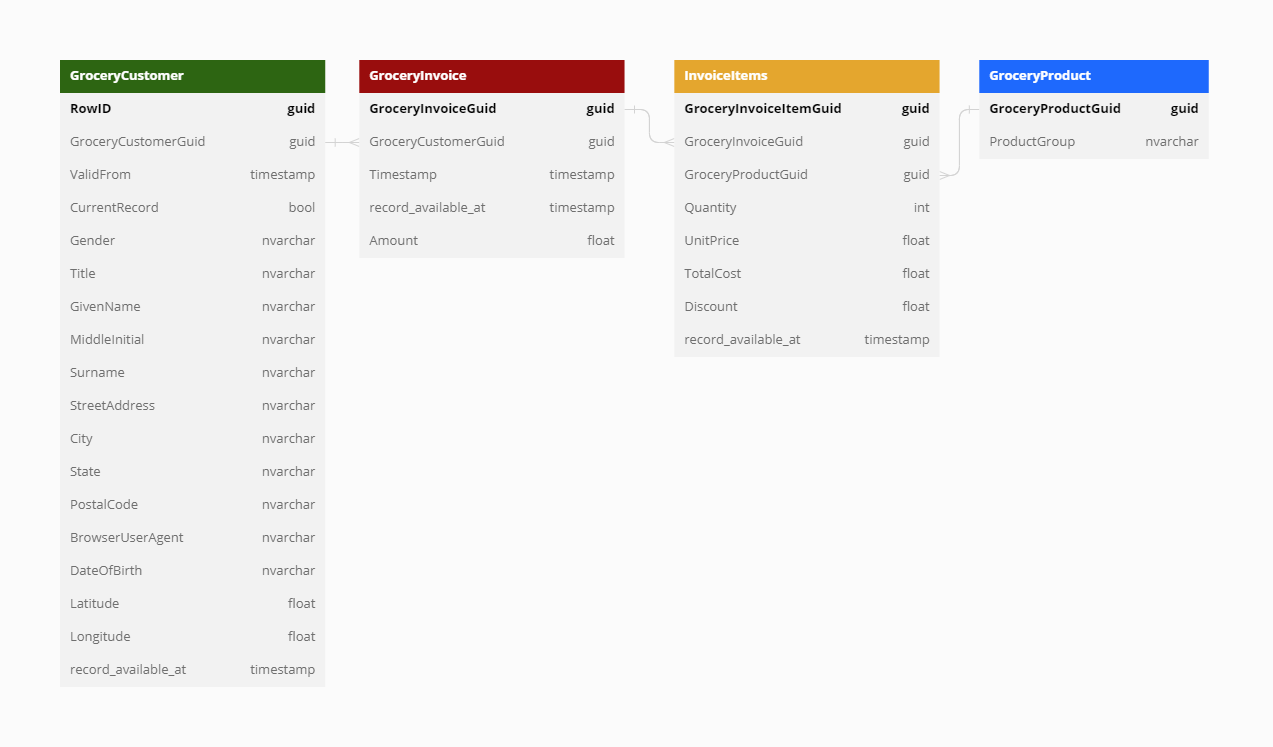

### Example: Load featurebyte tables

FeatureByte works on the principle of not moving data unnecessarily. So when you load a featurebyte table, you load its metadata, not the full contents of the table.

In [4]:
# get the tables for this catalog
grocery_customer_table = catalog.get_table("GROCERYCUSTOMER")
grocery_items_table = catalog.get_table("INVOICEITEMS")
grocery_invoice_table = catalog.get_table("GROCERYINVOICE")

### Concept: FeatureByte view

Views are cleaned versions of Catalog tables and offer a flexible and efficient way to work with Catalog tables. They allow operations like creating new columns, filtering records, conditionally editing columns, extracting lags and joining views, similar to Pandas. Unlike Pandas DataFrames, which require loading all data into memory, views are materialized only when needed during previews or feature materialization.

### Example: Syntax for creating views

In [5]:
# create views from the tables
grocery_customer_view = grocery_customer_table.get_view()
grocery_invoice_view = grocery_invoice_table.get_view()
grocery_items_view = grocery_items_table.get_view()

## Features

Learning Objectives

In this section you will learn:
* the definition of a feature
* about entities and primary entities
* how to list entities
* what is an observation set, and how to create one

### Concept: Feature

Input data that is used to train Machine Learning models and compute predictions is commonly referred to as features.

Features in FeatureByte are easily declared from Views in three ways: either as a Lookup feature, as an Aggregate feature or as a Cross Aggregate feature. Features can also be declared as a transformation of one or more existing features.

### Concept: Entity

An entity is a real-world object or concept that is represented by fields in the source tables. Entities facilitate automatic table join definitions, serve as the unit of analysis for feature engineering, and aid in organizing features, feature lists, and use cases.

All features must relate to an entity (or entities) as their primary unit of analysis.

### Concept: Feature Primary Entity
The primary entity of a feature defines the level of analysis for that feature.

The primary entity is usually a single entity. But in some instances, it may be a tuple of entities.

When a feature is a result of an aggregation grouped by multiple entities, the primary entity is a tuple of those entities. For instance, if a feature quantifies the interaction between a customer entity and a merchant entity in the past, such as the sum of transaction amounts grouped by customer and merchant in the past 4 weeks, the primary entity is the tuple of customer and merchant.

When a feature is derived from features with different primary entities, the primary entity is determined by the entity relationships, and the lowest level entity is selected as the primary entity. If the underlying entities have no relationship, the primary entity becomes a tuple of those entities.

For example, if a feature compares the basket of a customer with the average basket of customers in the same city, the primary entity is the customer since the customer entity is a child of the customer city entity. However, if the feature is the distance between the customer location and the merchant location, the primary entity becomes the tuple of customer and merchant since these entities do not have any parent-child relationship.

### Example: List entities

Note that in this case study, all entities except French state are used for joining tables. 

All entities can be used as a unit of analysis for features. For example, the French state entity can be used for creating features that aggregate over the geography.

In [6]:
# list the entities in the dataset
catalog.list_entities()

,name,serving_names,created_at
0,frenchstate,[FRENCHSTATE],2023-03-27 11:05:43.875
1,groceryproduct,[GROCERYPRODUCTGUID],2023-03-27 11:05:43.656
2,groceryinvoice,[GROCERYINVOICEGUID],2023-03-27 11:05:43.418
3,grocerycustomer,[GROCERYCUSTOMERGUID],2023-03-27 11:05:43.319


### Concept: Observation set

An observation set is a table of entity keys and points in time, for which you wish to materialize feature values. The entities keys define which entities a feature will materialize, and the points in time define at which timestamps.

### Example: Creating an observation set

Some use cases are about events, and require predictions to be triggered when a specified event occurs.

For a use case requiring predictions about a grocery customer whenever an invoice event occurs, your observation set may be sampled from historical invoices.

In [7]:
# get some invoice IDs and invoice event timestamps from 2022
filter = grocery_invoice_view["Timestamp"].dt.year == 2022
observation_set = (
    grocery_invoice_view[filter].sample(5)[["GroceryCustomerGuid", "Timestamp"]]
    .rename({
        "Timestamp": "POINT_IN_TIME",
        "GroceryCustomerGuid": "GROCERYCUSTOMERGUID",
    }, axis=1)
)
display(observation_set)

,GROCERYCUSTOMERGUID,POINT_IN_TIME
0,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32
1,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37
2,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48
3,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28
4,b721fbac-ed20-47c7-8bcc-c7033dddf773,2022-11-20 15:42:00


## Create a Lookup Feature

Learning Objectives

In this section you will learn:
* how to transform data
* what is a lookup feature
* how to create a lookup feature

### Concept: Transformation

A transformation is the process of changing the values of data in a view.

### Example: Transforming data in a view

In [8]:
# extract the operating system from the BrowserUserAgent column
grocery_customer_view["OperatingSystem"] = 'Unknown'
filter1 = grocery_customer_view.BrowserUserAgent.str.contains("Windows")
filter2 = grocery_customer_view.BrowserUserAgent.str.contains("Mac OS X")
grocery_customer_view.OperatingSystem[filter1] = 'Windows'
grocery_customer_view.OperatingSystem[filter2] = 'Mac'

# display a sample of the results
display(grocery_customer_view[["GroceryCustomerGuid", "BrowserUserAgent", "OperatingSystem"]].sample())

,GroceryCustomerGuid,ValidFrom,BrowserUserAgent,CurrentRecord,OperatingSystem
0,af30d1e6-1563-4866-9038-5a4c338f579d,2019-01-02 16:19:58,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,True,Windows
1,bfee3b1a-4315-4a63-aff3-65e3f926fc41,2019-01-09 17:26:09,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,True,Windows
2,9a6e097b-5297-4a31-b3a0-1443defb0915,2019-01-01 16:53:27,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,True,Windows
3,832a37b2-0a10-4f78-be47-42415f68be6c,2019-01-15 12:50:46,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,True,Mac
4,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2019-01-02 15:18:35,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,True,Mac
5,e3a927ee-ae24-496d-9c53-53f39ede0f9e,2019-03-16 17:22:56,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,True,Windows
6,cbc46908-6827-49b5-8cbc-c67223ca56c4,2019-01-07 16:44:43,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,True,Windows
7,e0df64b7-9104-439d-956e-dc5dc0a66f8f,2019-01-08 10:50:07,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,False,Windows
8,372f9d62-7479-43c4-a54c-8b49faff067c,2021-04-21 17:12:29,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:66...,True,Windows
9,850e590f-d786-4dd3-9c3f-836aa1402091,2022-03-24 15:24:04,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:6...,True,Windows


### Concept: Natural key

A natural key is a generally accepted identifier used to uniquely identify real-world objects. Examples are social security numbers that identify specific employee, or SKU numbers in a product dimension. In a Slowly Changing Dimension (SCD) table, a natural key is a column or a group of columns that remains constant over time and uniquely identifies each active row in the table at any point-in-time.

This key is crucial in maintaining and analyzing the historical changes made in the table. For example, in a customer SCD table, the customer ID can be considered a natural key since it remains constant, uniquely identifies each customer, is associated with only one set of customer attributes at a particular point-in-time, such as their address and phone number.

### Concept: Lookup feature

A Lookup feature refers to an entity’s attribute in a View at a specific point-in-time. Lookup features do not involve any aggregation processes.

When a FeatureByte view's primary key identifies an entity, it is simple to designate its attributes as features for that particular entity. Examples of Lookup features are a customer's birthplace retrieved from a Customer Dimension table or a transaction amount retrieved from a Transactions Event table.

In situations where an entity serves as the natural key of an SCD view, it is also possible to assign one of its attributes as a feature for that entity. However, in those cases, the feature is materialized through point-in-time joins, and the resulting value corresponds to the active row at the specified point-in-time of the feature request. For instance, a customer feature could be the customer's street address at the request's point-in-time. To acquire a feature value at a specific time before the request's point-in-time, an offset can be indicated. For example, by setting the offset to 9 weeks, the feature would represent the customer's street address 9 weeks before the request's point-in-time.

### Example: Syntax for declaring a lookup feature

In [9]:
# create a feature from the operating system column
customer_operating_system = grocery_customer_view.OperatingSystem.as_feature("OperatingSystem")

# create a multi-row preview of the feature values
display(customer_operating_system.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,OperatingSystem
0,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32,Windows
1,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37,Windows
2,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48,Mac
3,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28,Unknown
4,b721fbac-ed20-47c7-8bcc-c7033dddf773,2022-11-20 15:42:00,Windows


## Create an Aggregate Feature

Learning Objectives

In this section you will learn:
* what is an aggregate feature
* how to create a aggregate feature over a time window

### Concept: Aggregate feature

Aggregate features are an important type of feature engineering that involves applying various aggregation functions to a collection of data points to identify key patterns or trends. Common aggregation functions include the latest, count, sum, average, minimum, maximum, and standard deviation. However, it's often essential to consider the temporal aspect when conducting these aggregation operations.

There are four main types of aggregate features, including simple aggregates, aggregates over a window, aggregates "as at" a point-in-time, and aggregates of changes over a window.

### Concept: Aggregates over a window

Aggregates over a window refer to features that are generated by aggregating data within a specific time frame. These types of features are commonly used for analyzing event and item data.

### Example: Syntax for creating an aggregate feature over a window

In [10]:
# calculate the percentage discount for each grocery item
grocery_items_view["PercentageDiscount"] = grocery_items_view.Discount / (
    grocery_items_view.TotalCost + grocery_items_view.Discount
) * 100.0

# display a sample of the results
display(grocery_items_view.sample()[["GroceryCustomerGuid", "Discount", "TotalCost", "PercentageDiscount"]])

,GroceryCustomerGuid,Discount,TotalCost,PercentageDiscount
0,07fb68a0-cde2-46c1-897f-b14724f63cb7,0.41,0.88,31.782946
1,6178c39c-63f6-4f44-bcf2-3279705334a6,0.00,3.49,0.000000
2,838eda39-b1d3-4b03-b09d-eebeede52965,0.00,1.00,0.000000
3,b2994ad1-71a5-45a3-8154-9dfa3b6a0888,0.30,0.79,27.522936
4,fa6efaa1-fb76-46b2-8215-317029cf8ea6,1.50,4.99,23.112481
5,e1ee2840-b72f-448f-be0a-dac4ac177e54,0.00,0.25,0.000000
6,8ad5c37c-135a-41d8-86bc-dc85f188603e,0.20,2.38,7.751938
7,16e4cf29-598b-43e2-bf52-65f2ed80ac50,0.44,0.75,36.974790
8,641f1ed9-a8cd-4519-80e6-cc135c3910d4,0.00,10.14,0.000000
9,59728405-8f8a-4812-8c4b-56e5bb6aff89,0.27,2.42,10.037175


In [11]:
# get the maximum percentage discount on a grocery item for each customer over 90 days and 180 days,
# grouped by customer
customer_max_percent_discount = grocery_items_view.groupby(
    "GroceryCustomerGuid"
).aggregate_over(
    "PercentageDiscount",
    method=fb.AggFunc.MAX,
    feature_names=["MaxDiscount_30days", "MaxDiscount_90days"],   
    fill_value=0,
    windows=['30d', '90d']
)

# create a multi-row preview of the feature values
display(customer_max_percent_discount.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,MaxDiscount_30days,MaxDiscount_90days
0,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32,49.664430,49.664430
1,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37,49.367089,52.267303
2,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48,20.202020,40.828402
3,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28,56.410256,56.410256
4,b721fbac-ed20-47c7-8bcc-c7033dddf773,2022-11-20 15:42:00,52.380952,52.380952


## Save features

Learning Objectives

In this section you will learn:
* how to save features

### Example: Saving features to the Catalog

In [12]:
# save features to the Catalog
customer_operating_system.save()
customer_max_percent_discount.save()

## Reuse an Existing Feature

Learning Objectives

In this section you will learn:
* how to load a feature from the catalog
* how to view the feature lineage

### Example: Reuse an existing feature

In [13]:
# show the existing features
existing_features = catalog.list_features()

display(existing_features)

,name,dtype,readiness,online_enabled,tables,primary_tables,entities,primary_entities,created_at
0,MaxDiscount_90days,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-03-27 11:06:03.647
1,MaxDiscount_30days,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-03-27 11:06:02.456
2,OperatingSystem,VARCHAR,DRAFT,False,[GROCERYCUSTOMER],[GROCERYCUSTOMER],[grocerycustomer],[grocerycustomer],2023-03-27 11:06:01.365
3,CustomerPurchasedItemsEntropy_28d,FLOAT,DRAFT,False,"[GROCERYINVOICE, INVOICEITEMS]",[INVOICEITEMS],[grocerycustomer],[grocerycustomer],2023-03-27 11:05:48.641
4,CustomerInvoiceCount_60days,FLOAT,DRAFT,False,[GROCERYINVOICE],[GROCERYINVOICE],[grocerycustomer],[grocerycustomer],2023-03-27 11:05:47.818


In [14]:
# load a feature from the Catalog
customer_purchased_items_entropy_28days = catalog.get_feature("CustomerPurchasedItemsEntropy_28d")

# create a multi-row preview of the feature values
display(customer_purchased_items_entropy_28days.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,CustomerPurchasedItemsEntropy_28d
0,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32,4.133650
1,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37,3.920139
2,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48,2.271869
3,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28,3.963312
4,b721fbac-ed20-47c7-8bcc-c7033dddf773,2022-11-20 15:42:00,3.768368


### Concept: Feature Definition File

The feature definition file is the single source of truth for a feature version. The file is generated automatically after a feature is declared in the SDK and is stored in the FeatureByte Service.

This file uses the same SDK syntax as the feature declaration and provides an explicit outline of the intended operations of the feature declaration, including those that are inherited but not explicitly declared by the user. These operations may include feature job settings and cleaning operations inherited from tables metadata, for example.

### Example: Show Feature Definition File

In [15]:
# display the feature lineage for the feature we just loaded from the Catalog
print(customer_purchased_items_entropy_28days.definition)

# Generated by SDK version: 0.1.4
from bson import ObjectId
from featurebyte import ItemTable


# item_table name: "INVOICEITEMS", event_table name: "GROCERYINVOICE"
item_table = ItemTable.get_by_id(ObjectId("64217884ca42b16a1fc658b0"))
item_view = item_table.get_view(
    event_suffix=None,
    view_mode="manual",
    drop_column_names=[],
    column_cleaning_operations=[],
    event_drop_column_names=["record_available_at"],
    event_column_cleaning_operations=[],
    event_join_column_names=[
        "Timestamp",
        "GroceryInvoiceGuid",
        "GroceryCustomerGuid",
    ],
)
grouped = item_view.groupby(
    by_keys=["GroceryCustomerGuid"], category="GroceryProductGuid"
).aggregate_over(
    value_column=None,
    method="count",
    windows=["28d"],
    feature_names=["CustomerInventory_28d"],
    feature_job_setting={
        "blind_spot": "0s",
        "frequency": "3600s",
        "time_modulo_frequency": "90s",
    },
    skip_fill_na=True,
)
feat = grouped["CustomerInve

## Create a Feature List

Learning Objectives

In this section you will learn:
* how to create a feature list
* how to save a feature list

### Concept: Feature list

A Feature List is a set of features that is typically crafted to address a specific Use Case.

The primary entity of the Feature List, which determines its main focus, is determined by analyzing the relationship between the primary entities of the individual features listed. Usually, the primary entity of the Feature List aligns with that of the Use Case. Nevertheless, if there is a mismatch, the serving entities of the Feature List are utilized to evaluate its compatibility with the Use Case.

### Example: Create a feature list

In [16]:
# feature list can be constructed from both features and feature groups
grocery_features = fb.FeatureList([
    customer_operating_system,
    customer_max_percent_discount,
    customer_purchased_items_entropy_28days
    ], name="quick_start_grocery_features")

# materialize the feature values for this feature list
display(grocery_features.preview(observation_set))

,GROCERYCUSTOMERGUID,POINT_IN_TIME,OperatingSystem,MaxDiscount_30days,MaxDiscount_90days,CustomerPurchasedItemsEntropy_28d
0,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32,Windows,49.664430,49.664430,4.133650
1,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37,Windows,49.367089,52.267303,3.920139
2,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48,Mac,20.202020,40.828402,2.271869
3,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28,Unknown,56.410256,56.410256,3.963312
4,b721fbac-ed20-47c7-8bcc-c7033dddf773,2022-11-20 15:42:00,Windows,52.380952,52.380952,3.768368


### Example: Save a feature list

In [17]:
# save the feature list to the Catalog
grocery_features.save()

display(catalog.list_feature_lists())

Saving Feature(s) |████████████████████████████████████████| 4/4 [100%] in 0.0s (105.48/s)                              
Loading Feature(s) |████████████████████████████████████████| 4/4 [100%] in 1.1s (3.69/s)                               


,name,num_features,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,quick_start_grocery_features,4,DRAFT,False,0.0,0.0,"[GROCERYCUSTOMER, GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-03-27 11:06:13.717


In [18]:
# show the feature list in the Catalog

# get all feature lists
all_feature_lists = catalog.list_feature_lists()

# display the metadata for the feature list we just saved
# display only the matching feature list
display(all_feature_lists[all_feature_lists.name == grocery_features.name])

,name,num_features,status,deployed,readiness_frac,online_frac,tables,entities,created_at
0,quick_start_grocery_features,4,DRAFT,False,0.0,0.0,"[GROCERYCUSTOMER, GROCERYINVOICE, INVOICEITEMS]",[grocerycustomer],2023-03-27 11:06:13.717


## Materialize Feature Values

Learning Objectives

In this section you will learn:
* how to get historical values for a feature list
* how to deploy a feature list
* how to consume features via the API
* how to disable a deployed feature list

### Example: Get historical features

While the preview function materializes feature values when prototyping, the scalable approach to materialize features for training data is to use the get_historical_features function, which accesses cached feature values from the feature store.

In [19]:
# materialize the values
historical_data = grocery_features.get_historical_features(observation_set)

# display the historical data
display(historical_data)

Retrieving Historical Feature(s) |████████████████████████████████████████| 1/1 [100%] in 11.8s (0.08/s)                


,GROCERYCUSTOMERGUID,POINT_IN_TIME,MaxDiscount_90days,MaxDiscount_30days,OperatingSystem,CustomerPurchasedItemsEntropy_28d
0,7005c3a2-a903-4c15-9ffb-d52b0d5eba14,2022-10-31 15:05:32,49.664430,49.664430,Windows,4.133650
1,82a104d2-ad63-4079-8ccc-767c5b88afcb,2022-11-17 15:24:37,52.267303,49.367089,Windows,3.920139
2,a90ab8bf-1c87-4c98-811f-6b8cc8a7b7bd,2022-03-03 21:04:48,40.828402,20.202020,Mac,2.271869
3,ebd6f63f-9425-4175-8f69-457979d69741,2022-06-13 16:53:28,56.410256,56.410256,Unknown,3.963312
4,b721fbac-ed20-47c7-8bcc-c7033dddf773,2022-11-20 15:42:00,52.380952,52.380952,Windows,3.768368


### Example: Deploy a feature list

A Feature List is deployed to support online serving. This triggers the orchestration of the feature materialization into the online feature store

In [20]:
# deploy the new feature list, setting all the features to be production ready
grocery_features.deploy(enable=True, make_production_ready=True)

Loading Feature(s) |████████████████████████████████████████| 4/4 [100%] in 1.0s (4.04/s)                               
Done! |████████████████████████████████████████| 100% in 57.7s (1.73%/s)                                                


### Example: Consume features via API

Once a feature list has been deployed, you can consume it via the feature serving API.

You can either use a python template or a shell script where the generated code will use the curl command to send the request.

For the python template, set the language parameter value as 'python'.
For the shell script, set the language parameter value as 'sh'.

In [21]:
# get a python template for consuming the feature serving API
grocery_features.get_online_serving_code(language="python")

'from typing import Any, Dict\n\nimport pandas as pd\nimport requests\n\n\ndef request_features(entity_serving_names: Dict[str, Any]) -> pd.DataFrame:\n    """\n    Send POST request to online serving endpoint\n\n    Parameters\n    ----------\n    entity_serving_names: Dict[str, Any]\n        Entity serving name values to used for serving request\n\n    Returns\n    -------\n    pd.DataFrame\n    """\n    response = requests.post(\n        url="http://127.0.0.1:8088/feature_list/642178a1ca42b16a1fc658ca/online_features",\n        params={"catalog_id": "64217880ca42b16a1fc658ad"},\n        headers={"Content-Type": "application/json"},\n        json={"entity_serving_names": entity_serving_names},\n    )\n    assert response.status_code == 200, response.json()\n    return pd.DataFrame.from_dict(response.json()["features"])\n\n\nrequest_features([{"GROCERYCUSTOMERGUID": "007a07da-1525-49be-94d1-fc7251f46a66"}])'

Paste the output from the previous notebook cell into the following Python cell and run it. Note that in production there is no historical point_in_time parameter for materializing features.

In [22]:
# paste generated Python code here


### Example: Disable a deployment

In [23]:
# disable the feature list deployment
grocery_features.deploy(enable=False)

# show the deployed feature lists
feature_lists = catalog.list_feature_lists()
feature_lists = feature_lists[feature_lists.deployed == True]
display(feature_lists)

Loading Feature(s) |████████████████████████████████████████| 4/4 [100%] in 1.0s (3.99/s)                               
Done! |████████████████████████████████████████| 100% in 15.4s (6.51%/s)                                                


,name,num_features,status,deployed,readiness_frac,online_frac,tables,entities,created_at


## Next Steps

Now that you've completed the quick-start feature engineering tutorial, you can put your knowledge into practice or learn more:<br>
1. Put your knowledge into practice by creating features in the "credit card dataset feature engineering playground" or "healthcare dataset feature engineering playground" catalogs
2. Learn more about feature engineering via the "Deep Dive Feature Engineering" tutorial
3. Learn about data modeling via the "Deep Dive Data Modeling" tutorial